# PyTASER Examples


The examples given below use electronic structure information from the Materials Project database. They require an API key that you can get from https://materialsproject.org/open



As the database is built from density functional theory calculations using a semi-local exchange-correlation functional, the band gaps are underestimated, so we apply a scissors operator to recover the experimental bandgap in each case. This is necessary to directly compared predicted and modelled spectra.

## Setup

In [2]:
import sys
sys.path.append('/Users/wooyoungwon/Dropbox/program/PyTASER-main/PyTASER/pytaser/')
from pytaser import generator, plotter
%matplotlib inline

key = 'kZ8rIdQEyOpsf2JX'  # insert your own Materias Project key

## GaAs

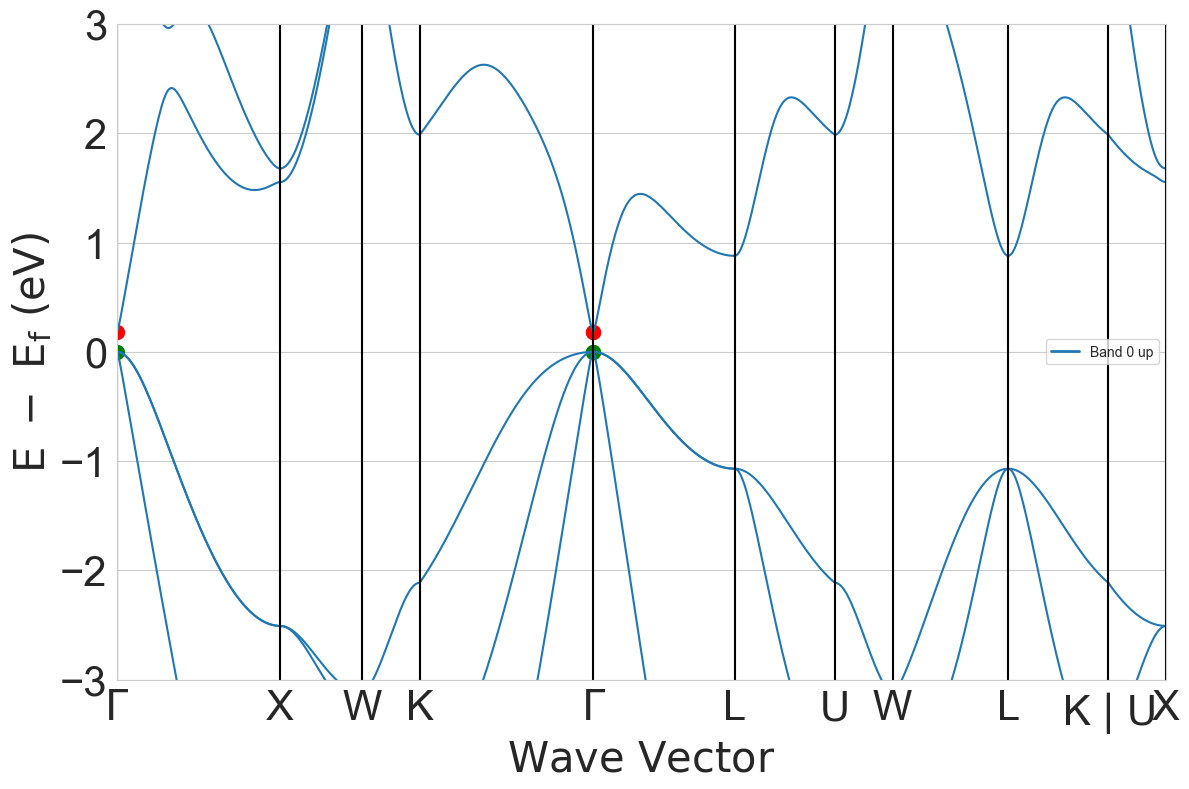

In [6]:
#Band structure read from pymatgen 
from pymatgen.ext.matproj import MPRester
from pymatgen.ext.matproj import TaskType
from pymatgen.electronic_structure.plotter import BSPlotter
api = MPRester(key)
bs = api.get_bandstructure_by_material_id("mp-2534")

from pymatgen.electronic_structure.plotter import BSPlotter
plt = BSPlotter(bs).get_plot(vbm_cbm_marker=True,ylim=[-3,+3])

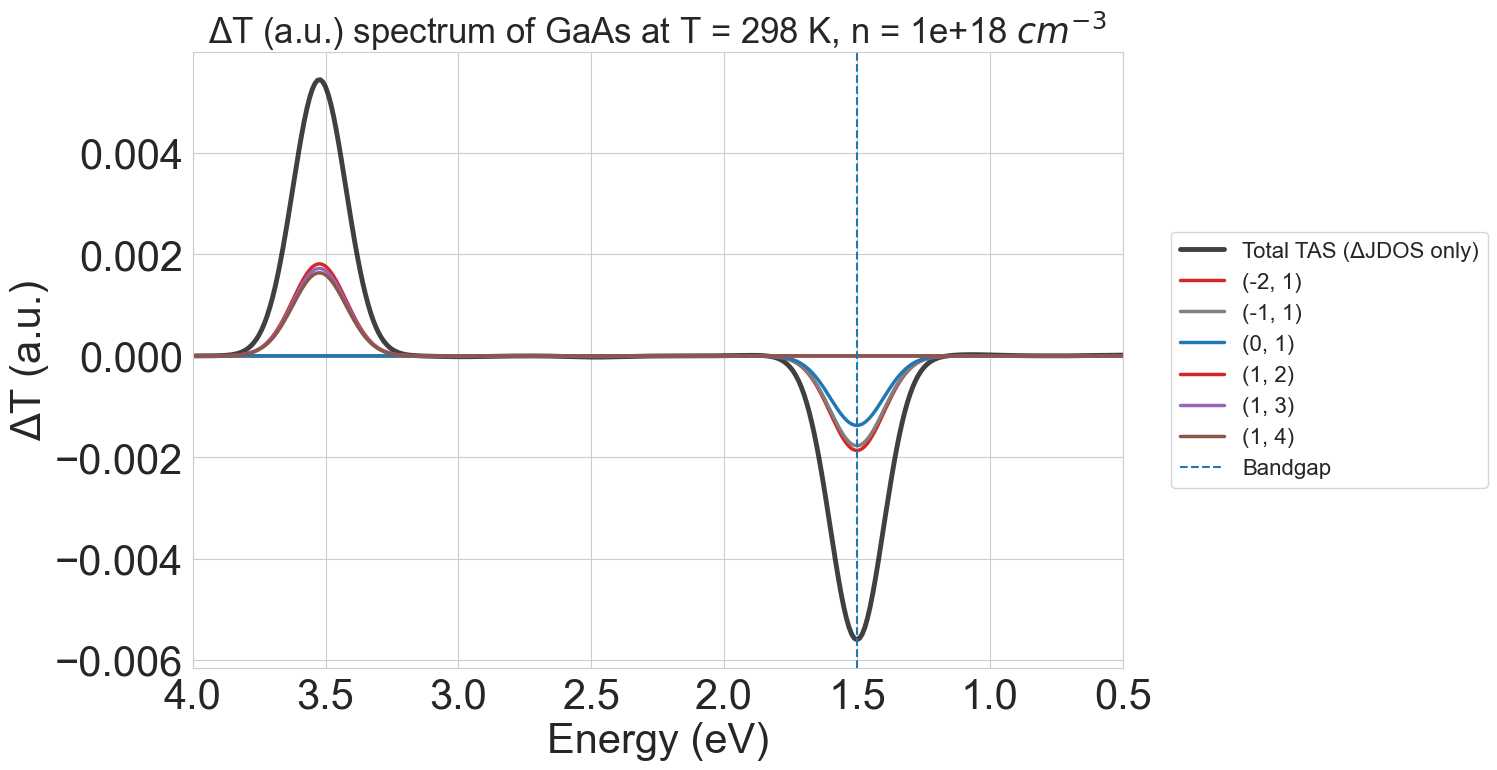

In [5]:
# Setting values
temp = 298 # temperature in Kelvin
conc = 1e18 # carrier concentration per cm3 
bandgap = 1.5 # eV, standard value at T = 300 K
key ="kZ8rIdQEyOpsf2JX"

# Run pyTASER
data = generator.TASGenerator.from_mpid("mp-2534", bandgap, api_key=key)
process = data.generate_tas(temp, conc)
plot = plotter.TASPlotter(process, material_name="GaAs")

# Output energy plot 
energyplot = plot.get_plot(
    xaxis="energy", transition_cutoff=0.50, xmin=0.5, xmax=4, yaxis="tas")
# Reverse axis for better comparison to experiment
# You can change xaxis to "wavelength" 
energyplot.gca().invert_xaxis()

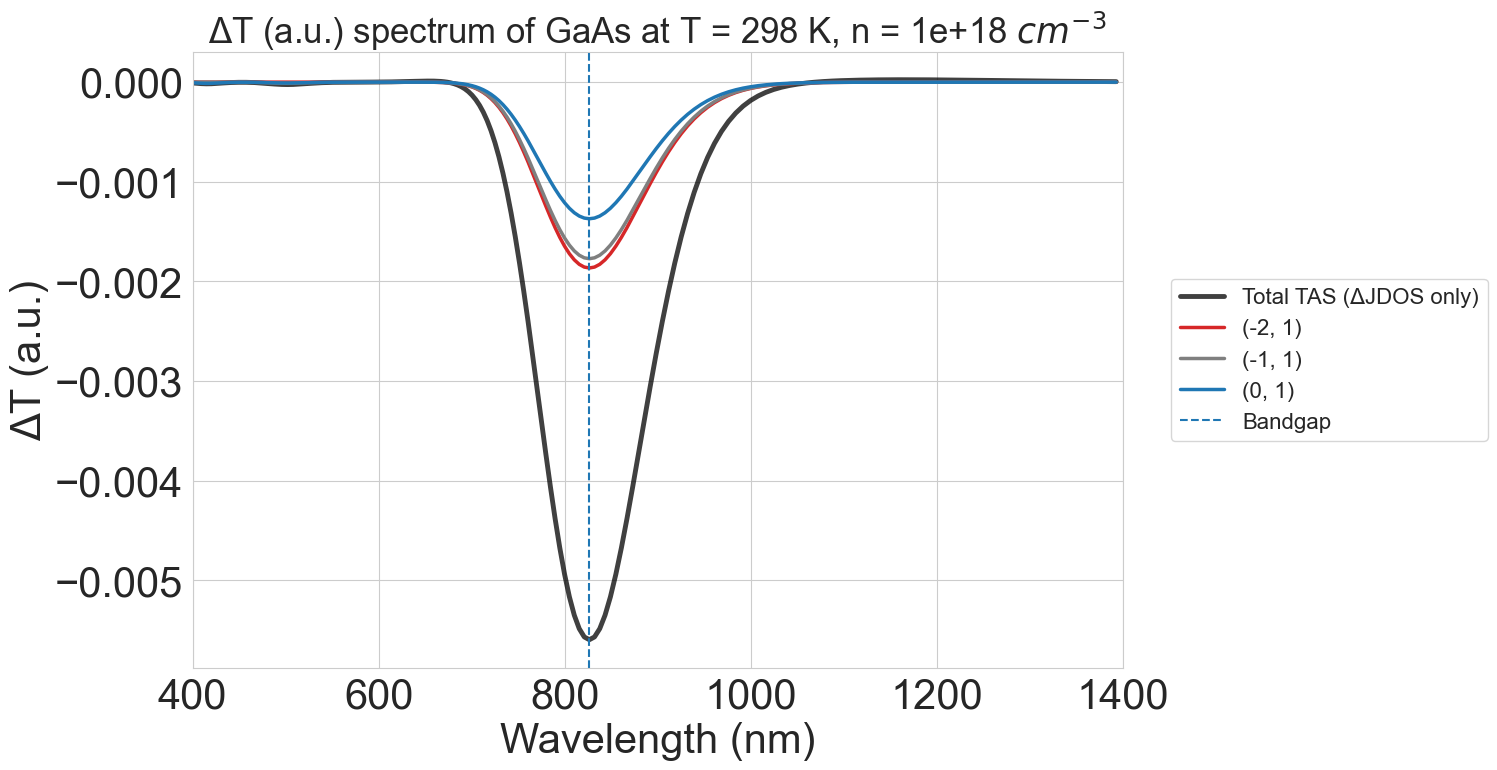

In [9]:
# Output wavelength plot
wavelength_plot = plot.get_plot(xaxis="wavelength", transition_cutoff=0.03, xmin=400, xmax=1400, yaxis="tas")

## PyTASER workflow with DFT

## rutile-TiO2

In [8]:
## Load DFT bandstructure and dos to prepare PyTASER run

# Read vasprun.xml,get band information
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
import os
import glob
from pymatgen.electronic_structure.bandstructure import get_reconstructed_band_structure

folders_bs = sorted(glob.glob("./TiO2/band/split-0*/"))
vaspruns_bs = []
for fol in folders_bs:
    vr_file = os.path.join(fol, "vasprun.xml")
    vaspruns_bs.append(vr_file)

# Get bandstructure and band gap
bandstructures = []
for vr_file in vaspruns_bs:
    vr = BSVasprun(vr_file, parse_projected_eigen=True)
    bs = vr.get_band_structure(line_mode=False)
    bandstructures.append(bs)
bandstructure = get_reconstructed_band_structure(bandstructures)

# Uniform k-point mesh band structure to get kpoint weight
kweights=[]
for fol in folders_bs:
    vr_file = os.path.join(fol, "vasprun.xml")
    vr = Vasprun(vr_file, parse_projected_eigen=False)
    kweight = vr.actual_kpoints_weights
    kweights.extend(kweight)

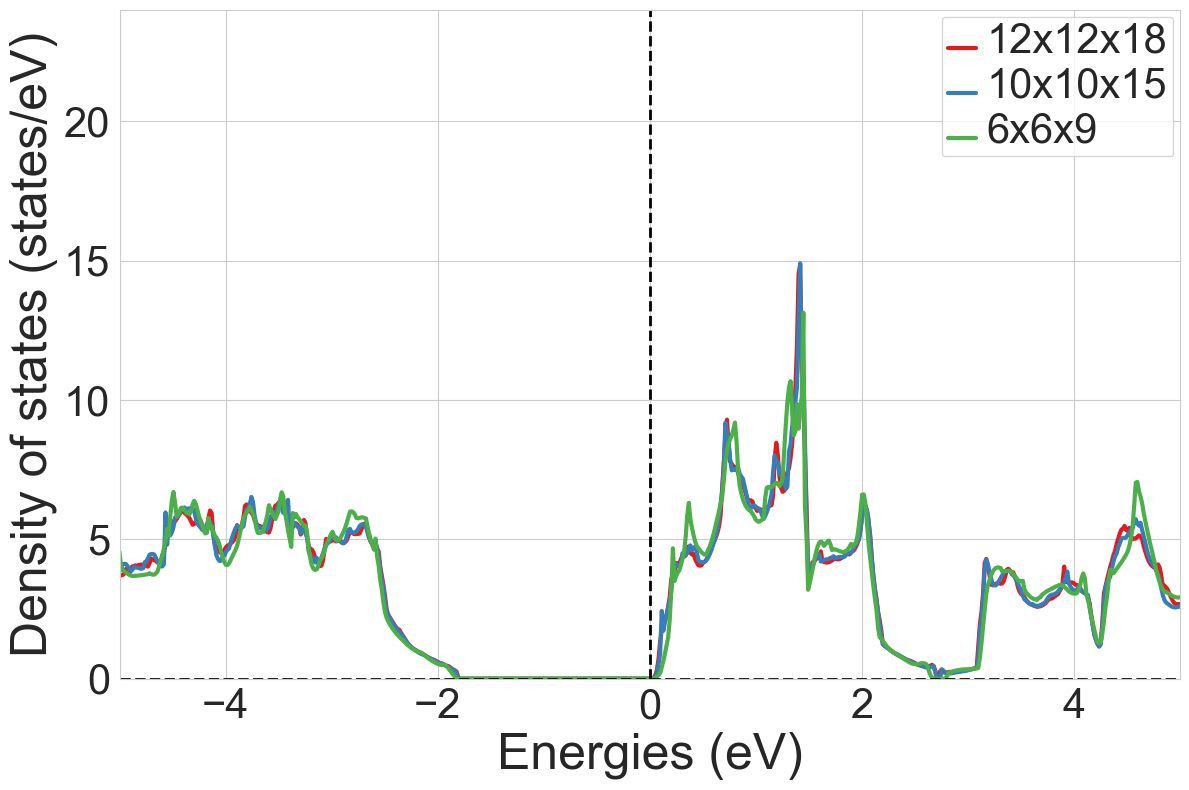

In [9]:
# DOS converge check, here we test 6x6x9, 10x10x15, 12x12x18
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp import Vasprun

vasprun_dos = Vasprun("./TiO2/dostest/669/vasprun.xml")
dos1 = vasprun_dos.complete_dos
vasprun_dos = Vasprun("./TiO2/dostest/101015/vasprun.xml")
dos2 = vasprun_dos.complete_dos
vasprun_dos = Vasprun("./TiO2/dostest/121218/vasprun.xml")
dos3 = vasprun_dos.complete_dos


plotter_ = DosPlotter(zero_at_efermi= True, stack= False)
plotter_.add_dos_dict({"6x6x9":dos1,"10x10x15": dos2, "12x12x18": dos3})
plotter_.show(xlim=[-5, 5], ylim=[0, 24])

In [10]:
# Read vasprun.xml,get dos information
vasprun_dos = Vasprun("./TiO2/band/split-02/vasprun.xml")
dos = vasprun_dos.complete_dos
bandstructure = vasprun_dos.get_band_structure(line_mode=False)

In [11]:
# Use scissor function to match bandstructure and dos with given bandgap
# This process will change bandstructure -> new_bandstructure, dos -> new_dos)
from copy import deepcopy

bandgap = 3.4  # value from hybrid calculation
new_bandstructure, new_dos = generator.set_bandgap(bandstructure, dos, bandgap) 

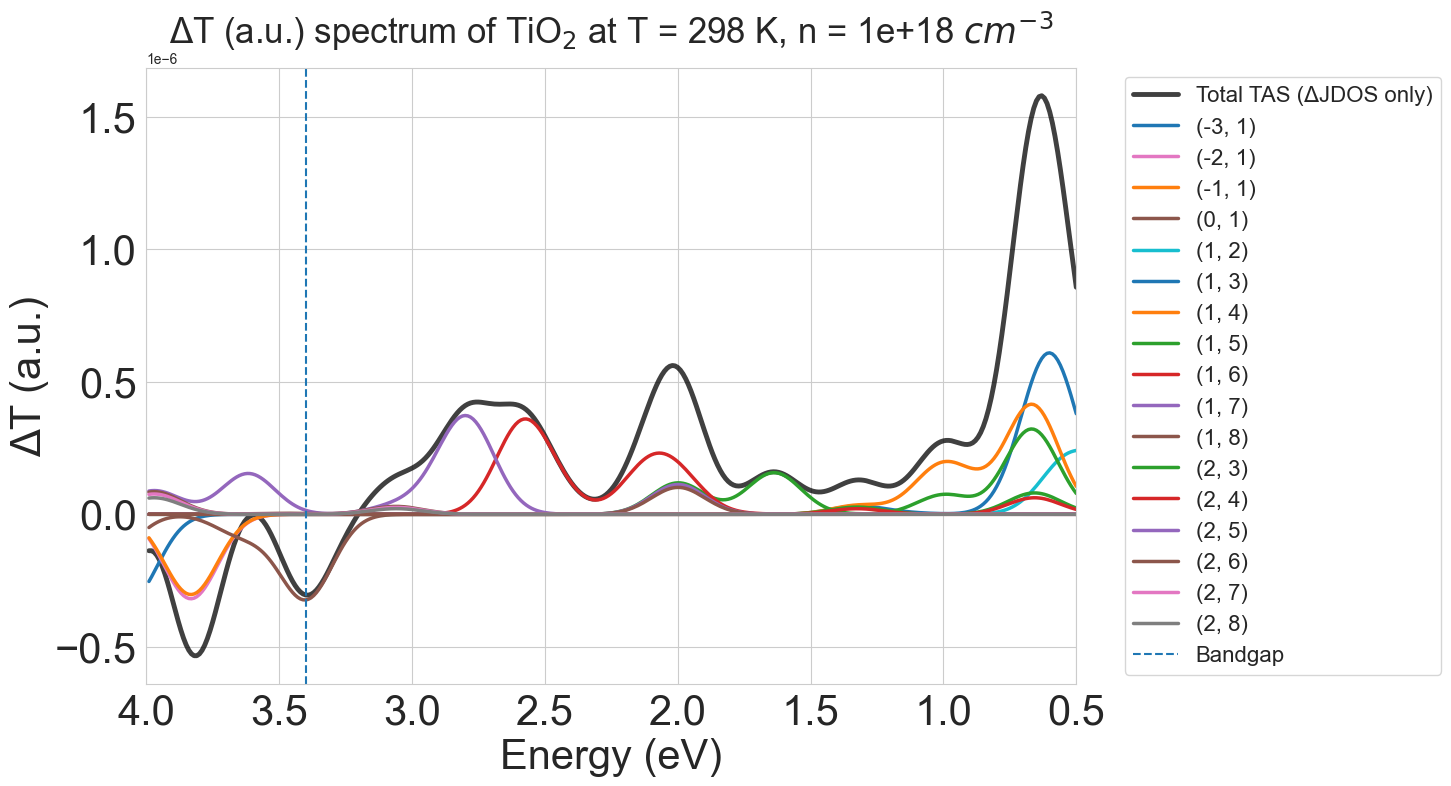

In [12]:
# Setting values
temp = 298 # temperature in Kelvin
conc = 1e18 # carrier concentration per cm3 

# Run pyTASER
data_dft = generator.TASGenerator(new_bandstructure, kweights, new_dos)
process_dft= data_dft.generate_tas(energy_min=0.0, energy_max=5, temp=temp, conc=conc)
plot_dft = plotter.TASPlotter(process_dft, material_name="TiO2")

# Output energy plot 
energy_plot_dft = plot_dft.get_plot(xaxis="energy", transition_cutoff=0.03, xmin=0.5, xmax=4, yaxis="tas")
# Reverse axis for better comparison to experiment
# You can change xaxis to "wavelength" 
energy_plot_dft.gca().invert_xaxis()

## Comparison between database and DFT calculation data by heatmap

In [56]:
# Read TiO2 data and generate TAS from materials project
process_mp = generator.TASGenerator.from_mpid("mp-2657", bandgap, api_key=key).generate_tas(temp,conc)
plot_mp = plotter.TASPlotter(process_mp, material_name="TiO2")

The above code to generate a TAS object can sometimes take a little while to run. To save time when rerunning our analysis, we can save the generated TAS object to a `json` file like this:

In [59]:
from monty.serialization import dumpfn
dumpfn(process_mp, "mp-2657.json")

When we want to redo some of this analysis, in this notebook or a new one, we can now load the TAS object from the `json` file without having to re-parse the Materials Project data, like this:

In [60]:
from monty.serialization import loadfn
process_mp = loadfn("mp-2657.json")

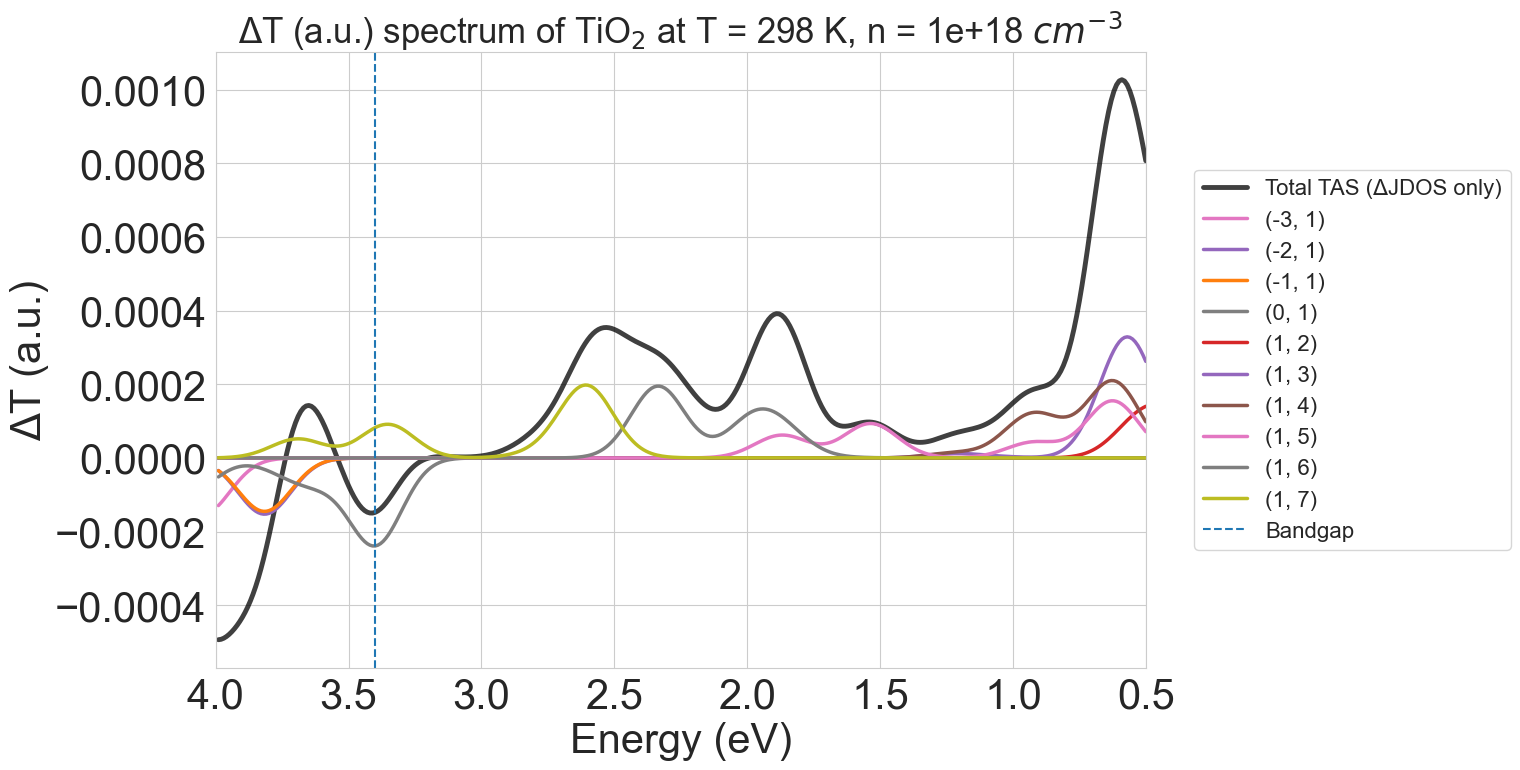

In [61]:
# TiO2 TAS spectra from MP
plot_mp = plotter.TASPlotter(process_mp, material_name="TiO2")
energy_plot_mp = plot_mp.get_plot(xaxis="energy", transition_cutoff=0.35, xmin=0.5, xmax=4, yaxis="tas")
energy_plot_mp.gca().invert_xaxis()

In [62]:
tas_container = [process_mp, process_dft]
tas_name = ["Database", "DFT"]

In [75]:
import pandas as pd
df = pd.DataFrame(tas_name, columns = ['material ID'])
df['tas'] = tas_container

# Code to get a dataframe of important values
tas = pd.DataFrame(columns=['Material ID','Total delta T'])
energy_mesh = []

# Get Material ID and total tas from tas_container class and add to the tas dataframe
data_list = []
for i in range(len(tas_name)):
    current_tas = df.iloc[i]['tas']
    data = {'Material ID':tas_name[i],'Total delta T': current_tas.tas_total}
    data_list.append(data)
    energy_mesh.append(current_tas.energy_mesh_ev)

tas = pd.concat([tas, pd.DataFrame(data_list)], ignore_index=True)

# Split list into columns
split = pd.DataFrame(tas['Total delta T'].tolist())
tas = pd.concat([tas, split], axis=1).drop('Total delta T', axis=1).set_index('Material ID')

# Create tas csv file
tas.to_csv('tas.csv')
data = pd.read_csv('tas.csv')
data.head()

,Material ID,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,Database,3.660503e-06,4.795239e-06,6.220610e-06,7.991370e-06,1.016693e-05,1.281023e-05,1.598608e-05,1.975920e-05,2.419172e-05,...,-8.234826e-05,-8.286709e-05,-8.278287e-05,-8.201012e-05,-8.050050e-05,-7.824551e-05,-7.527711e-05,-7.166667e-05,-6.752221e-05,-6.298423e-05
1,DFT,7.274846e-09,9.531737e-09,1.236476e-08,1.588051e-08,2.019340e-08,2.542266e-08,3.168841e-08,3.910652e-08,4.778255e-08,...,5.337424e-07,4.629214e-07,3.901820e-07,3.172037e-07,2.455474e-07,1.766163e-07,1.116247e-07,5.157759e-08,-2.740909e-09,-5.077073e-08


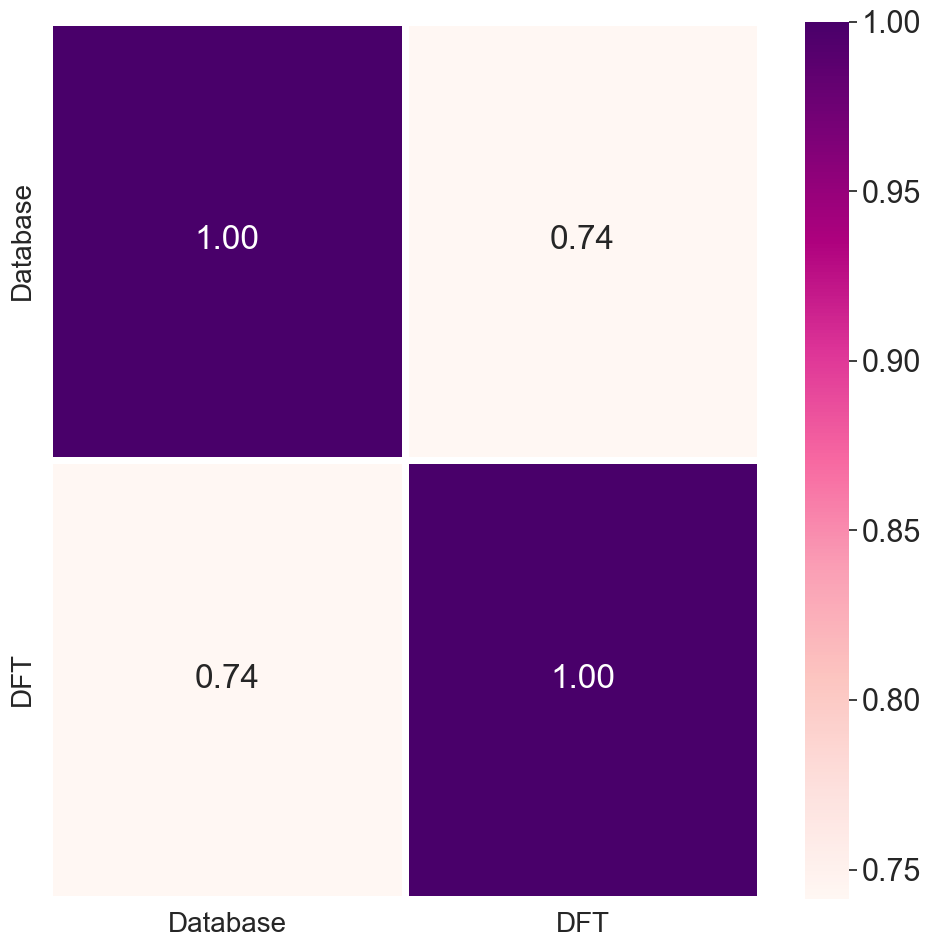

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate heatmap
tas = pd.read_csv('tas.csv', index_col=0)
matrix = tas.T.corr()
matrix = matrix[abs(matrix)>=0.01]

sns.heatmap(matrix, annot=True, fmt='.2f', linewidths=5, cmap='RdPu')
sns.set(rc = {'figure.figsize':(10,10)},font_scale = 2)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout()
plt.show()